# Analysis of model convergence based on reported deaths for heavily affected countries

This notebook explores the convergence of the model on a consistant prediction as more data is fed into it.


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
# %matplotlib notebook

In [3]:
import os
from pathlib import Path
from matplotlib import pyplot as plt

## Method

This analysis is done by comparing the reported, modelled and forecasted deaths for 4 countries: France, Spain, Italy and the UK. These countries were picked as they present similar epidemics as judged by number of deaths. They do however present different lags with Italy's being the most advanced, followed by Spain and France, and finally followed by the UK.

Simulations provided with increasing days of reports are plotted on the same graph. "Convergence" is assessed visually by finding the point at which modelled and forecasted mean lines stop changing as more data is added.

Below are the plotting functions. In each plot data is grouped by code version and the fitting conditions. For France two fitting conditions exist:

- Fitting with influence from Europe and French regions;
- Fitting with influence from French regions only;

The effect of this difference has not been evaluated yet.

In [4]:
from model_analysis import * 

In [5]:
run_manifest = read_manifest('run-manifest.csv')
analysis_set = get_analysis_set(run_manifest)

In [6]:
def group_by_version_and_country_num(df, x):
    countries = "France only"
    if df.loc[x, "number of countries"]>1:
        countries = "Europe"
    return (df.loc[x, "version"], countries)

groups = analysis_set.groupby(lambda x : group_by_version_and_country_num(analysis_set, x))

prop_cycle = icl_plot.default_color_cycle * icl_plot.cycler(
    linestyle=[ '-', '--'],
    marker=[' ', 'v'],
    markevery=[ 1, 4]
)
def plot_groups(groups, country, prop_cycle, cond_group=lambda x: True):
    for group in groups:
        print(group[0])
        if not cond_group(group[0]):
            continue
        _, ax = plt.subplots()
        ax.set_title(f"model {group[0][0]} - fitting {group[0][1]}")
        # Plot data for longest data stream
        model = group[1].iloc[-1]["model"]
        plot_report_country(model.data["modelling"], country, ax=ax, 
            color='k', marker='o', markevery=1, linestyle='none')
        
        # For every row of each group plot the model and forecast in the same colour.
        ax.set_prop_cycle(prop_cycle)
        for row in group[1].iterrows():
            model = row[1]["model"]
            plot_model_country(model.data["modelling"], country, ax=ax)
            plot_forecast_country(model.data["forecasting"], country, ax=ax)
        # Format plots
        remove_confidence_interval_legend_labels(ax)
        modify_legend(ax, bbox_to_anchor=(1.04, 1.0), loc='upper left')
        ax.set_ylim(1, 2000)
        icl_plot.axis_date_limits(ax, min_date='2020-03-10', max_date='2020-05-01')


## Analysis of convergence on France

The next few plots display data for France as a whole modelled from a range of different dates.


(' v2', 'Europe')
Plotting reports for France (Reported deaths to 2020-04-23)
Plotting model for France (model to 2020-03-24)
Plotting forecast for France (forecast from 2020-03-24)
Plotting model for France (model to 2020-04-01)
Plotting forecast for France (forecast from 2020-04-01)
Plotting model for France (model to 2020-04-16)
Plotting forecast for France (forecast from 2020-04-15)
Plotting model for France (model to 2020-04-16)
Plotting forecast for France (forecast from 2020-04-16)
Plotting model for France (model to 2020-04-19)
Plotting forecast for France (forecast from 2020-04-18)
Plotting model for France (model to 2020-04-20)
Plotting forecast for France (forecast from 2020-04-20)
Plotting model for France (model to 2020-04-23)
Plotting forecast for France (forecast from 2020-04-23)
(' v2', 'France only')
Plotting reports for France (Reported deaths to 2020-04-23)
Plotting model for France (model to 2020-03-24)
Plotting forecast for France (forecast from 2020-03-24)
Plottin

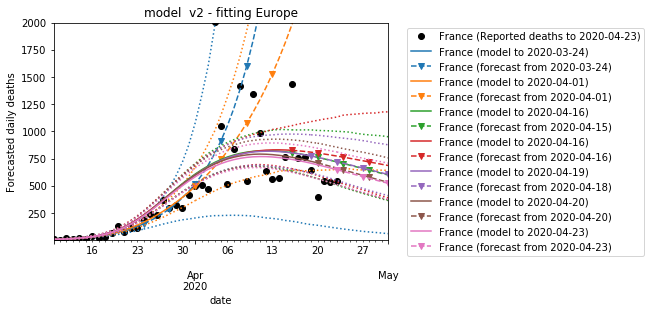

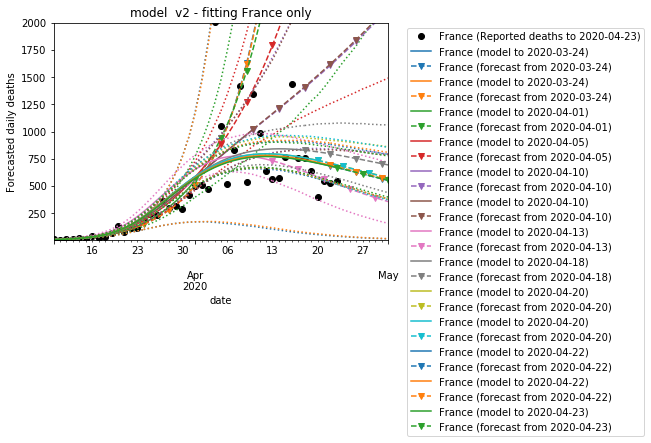

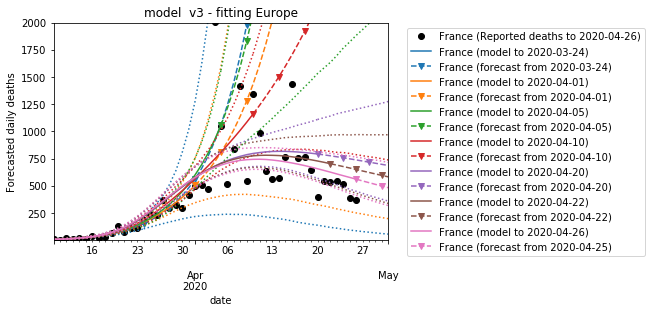

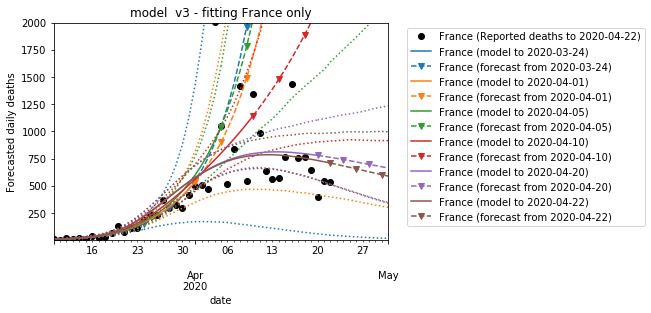

In [7]:
plot_groups(groups, "France", prop_cycle)

Clear convergence of the model on a single trend is observed after the 20/04. We observe oscillations 
around this trend in the week leading up to it (from the 13/04).

An hypothesis for this slow convergence is that the change introduced by the count of EHPAD fatalities. 
This is seen by a rapid change
in predictions in the date range 05/04-18/04 as the number of deaths in care homes reported reflected values since the start of the epidemic.

Convergence of the model is done in 35 days after the introduction of a lockdown.

## Case study of Spain, Italy and the UK

Studying three countries with different epidemic startdate and different lockdown dates, allows a to evaluate the number of samples after an NPI that the model requires to converge.

The graphs below plot the models and forecasts at a range of dates.

(' v2', 'Europe')
Plotting reports for Spain (Reported deaths to 2020-04-23)
Plotting model for Spain (model to 2020-03-24)
Plotting forecast for Spain (forecast from 2020-03-24)
Plotting model for Spain (model to 2020-04-01)
Plotting forecast for Spain (forecast from 2020-04-01)
Plotting model for Spain (model to 2020-04-16)
Plotting forecast for Spain (forecast from 2020-04-15)
Plotting model for Spain (model to 2020-04-16)
Plotting forecast for Spain (forecast from 2020-04-16)
Plotting model for Spain (model to 2020-04-19)
Plotting forecast for Spain (forecast from 2020-04-18)
Plotting model for Spain (model to 2020-04-20)
Plotting forecast for Spain (forecast from 2020-04-20)
Plotting model for Spain (model to 2020-04-23)
Plotting forecast for Spain (forecast from 2020-04-23)
(' v2', 'France only')
(' v3', 'Europe')
Plotting reports for Spain (Reported deaths to 2020-04-26)
Plotting model for Spain (model to 2020-03-24)
Plotting forecast for Spain (forecast from 2020-03-24)
Plottin

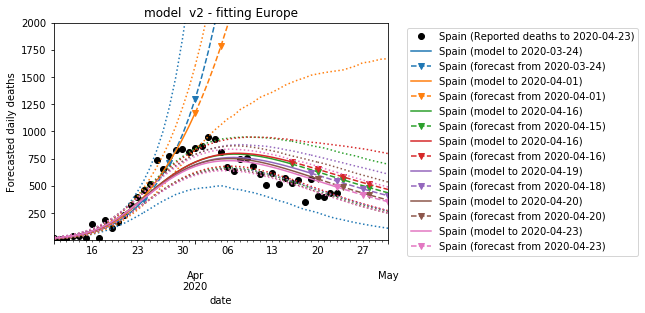

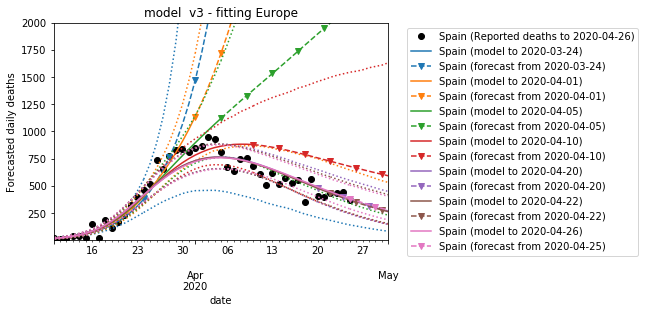

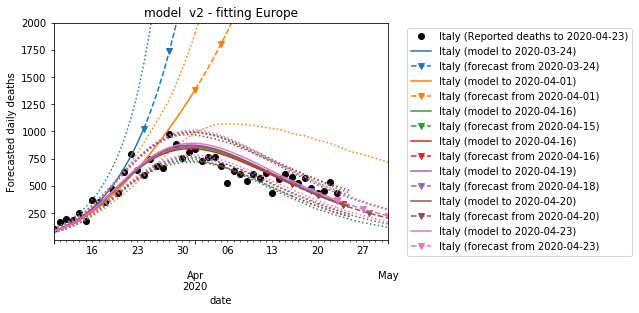

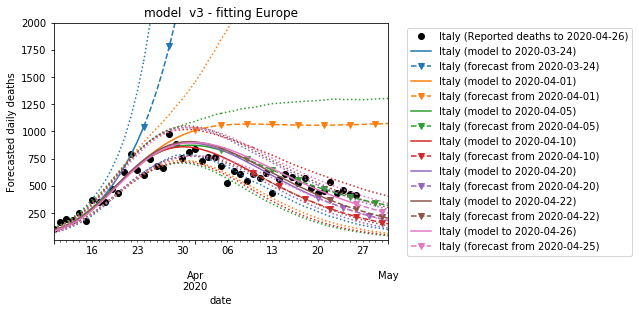

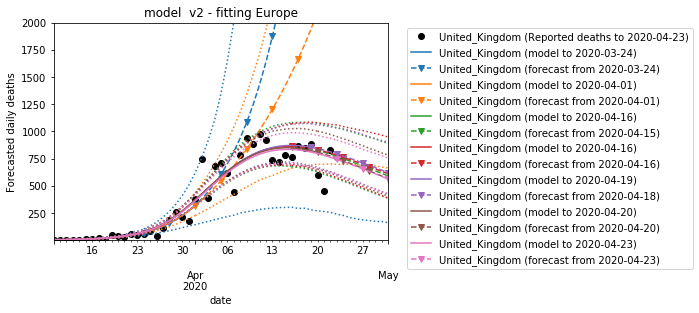

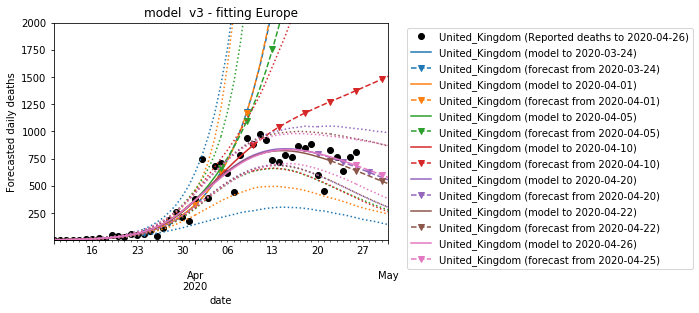

In [8]:
func = lambda x: x[1]=="Europe"

plot_groups(groups, "Spain", prop_cycle, func)
plot_groups(groups, "Italy", prop_cycle, func)
plot_groups(groups, "United_Kingdom", prop_cycle, func)

from these we can establish a rough
time after which the model has converged and the mean behaviour reflects something close to the observed
behaviour. For each country this point is reached:

- Spain between the 10/04/2020 and the 15th 
- Italy around the 04/04/2020 +- 1 day 
- UK around the 16/04/2020 +- 1 day 

Recalling lockdowns:

- Spain 14/03/2020
- Italy 10/03/2020
- UK 24/03/2020

This implies a time for convergence of the model of:

- 28 days
- 25 days
- 23 days

## Conclusions

This visual analysis suggests that the model converges on the correct epidemiological parameters
when provided with more than three weeks of data. 

The change of reporting method in France did inpact convergence delaying it by 7 to 12 days based
on the behaviours of countries with similar epidemics.